In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from pathlib import Path
import ast
from IPython.display import display
import numpy as np
import seaborn as sns

override_files = (list(Path('.').glob('**/overrides.yaml')))
df = pd.DataFrame()
for override_file in override_files:    
       
    factors = yaml.safe_load(override_file.read_text())
    factors = dict([elm.split('=') for elm in factors if elm[0] != '+'])
    
    factors = pd.DataFrame(factors,index=range(0,int(factors['epochs']))) #Factors df with a duplicate row per epoch
    factors['epoch'] = list(range(1,int(factors.epochs[0]) + 1 )) #Adding epoch number to each row
    
    log_file =  override_file.parent.parent /'TrainModel.log'
    with open(log_file) as f:
        metrics = [log.split("- ")[-1].strip().split(': ') for log in f.readlines() if '__main__' in log]
        metrics = pd.DataFrame({k:ast.literal_eval(v) for k,v in metrics}) #Metric df containing the log metrics
    
    #concat factor and metrics dfs to the final df
    df = pd.concat([df, pd.concat([factors, metrics],axis=1)])
    

In [7]:
df = df.rename(columns={'modelconf.layersconf.Random_Flip.mode':'Random_Flip', 'modelconf.layersconf.Random_Brightness.factor':'Random_Brightness', 'modelconf.layersconf.Random_Contrast.factor':'Random_Contrast'})
df.epoch = df.epoch.astype('uint8')
df.Random_Brightness = df.Random_Brightness.astype('float64')
df.Random_Contrast = df.Random_Contrast.astype('float64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 0 to 19
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   modelconf            1500 non-null   object 
 1   Random_Flip          1500 non-null   object 
 2   Random_Brightness    1500 non-null   float64
 3   Random_Contrast      1500 non-null   float64
 4   epochs               1500 non-null   object 
 5   epoch                1500 non-null   uint8  
 6   Train Accuracy       1500 non-null   float64
 7   Train Loss           1500 non-null   float64
 8   Validation Accuracy  1500 non-null   float64
 9   Validation Loss      1500 non-null   float64
dtypes: float64(6), object(3), uint8(1)
memory usage: 118.7+ KB


In [9]:
desc = df[df.epoch > 6].groupby(['Random_Flip','Random_Brightness', 'Random_Contrast']).describe()
val_acc = desc['Validation Accuracy'].reset_index().sort_values('50%', ascending=False)
train_acc = desc['Train Accuracy'].reset_index().sort_values('50%', ascending=False)

In [10]:
val_acc.iloc[0:6,:]

,Random_Flip,Random_Brightness,Random_Contrast,count,mean,std,min,25%,50%,75%,max
65,vertical,0.3,0.0,14.0,0.745607,0.040133,0.652315,0.719881,0.748734,0.761939,0.811505
6,horizontal,0.1,0.1,14.0,0.712994,0.025488,0.670405,0.691208,0.719790,0.733086,0.744935
20,horizontal,0.4,0.0,14.0,0.698677,0.043847,0.552460,0.706766,0.710926,0.714092,0.732272
3,horizontal,0.0,0.3,14.0,0.689167,0.064822,0.506512,0.701972,0.710564,0.719428,0.748553
67,vertical,0.3,0.2,14.0,0.692914,0.039616,0.597323,0.680535,0.704776,0.720152,0.736614
11,horizontal,0.2,0.1,14.0,0.699245,0.015740,0.666064,0.692203,0.703329,0.710836,0.718524


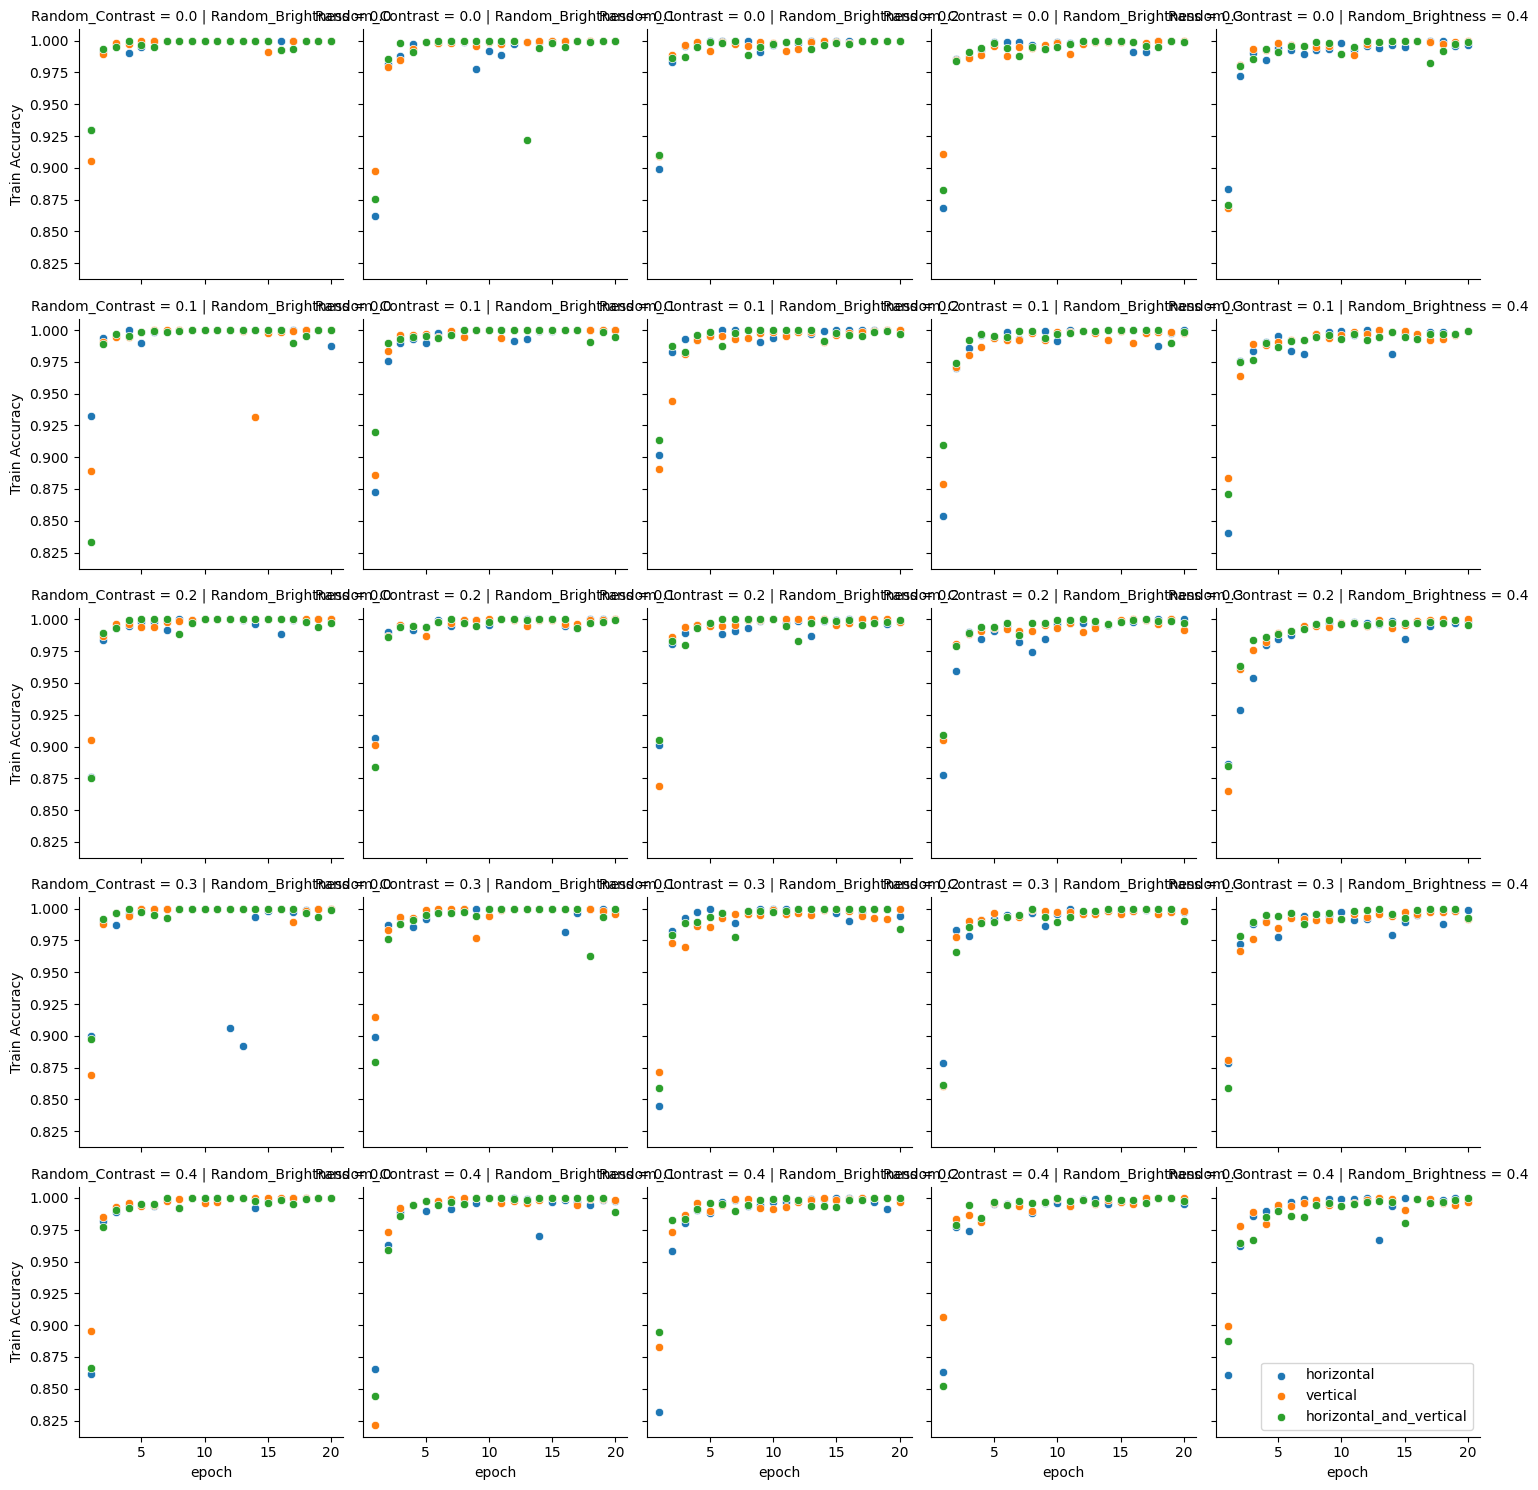

In [11]:
g = sns.FacetGrid(df, col = 'Random_Brightness', row = 'Random_Contrast', hue='Random_Flip')
g.map_dataframe(sns.scatterplot, x='epoch', y='Train Accuracy')
plt.tight_layout()
plt.legend()

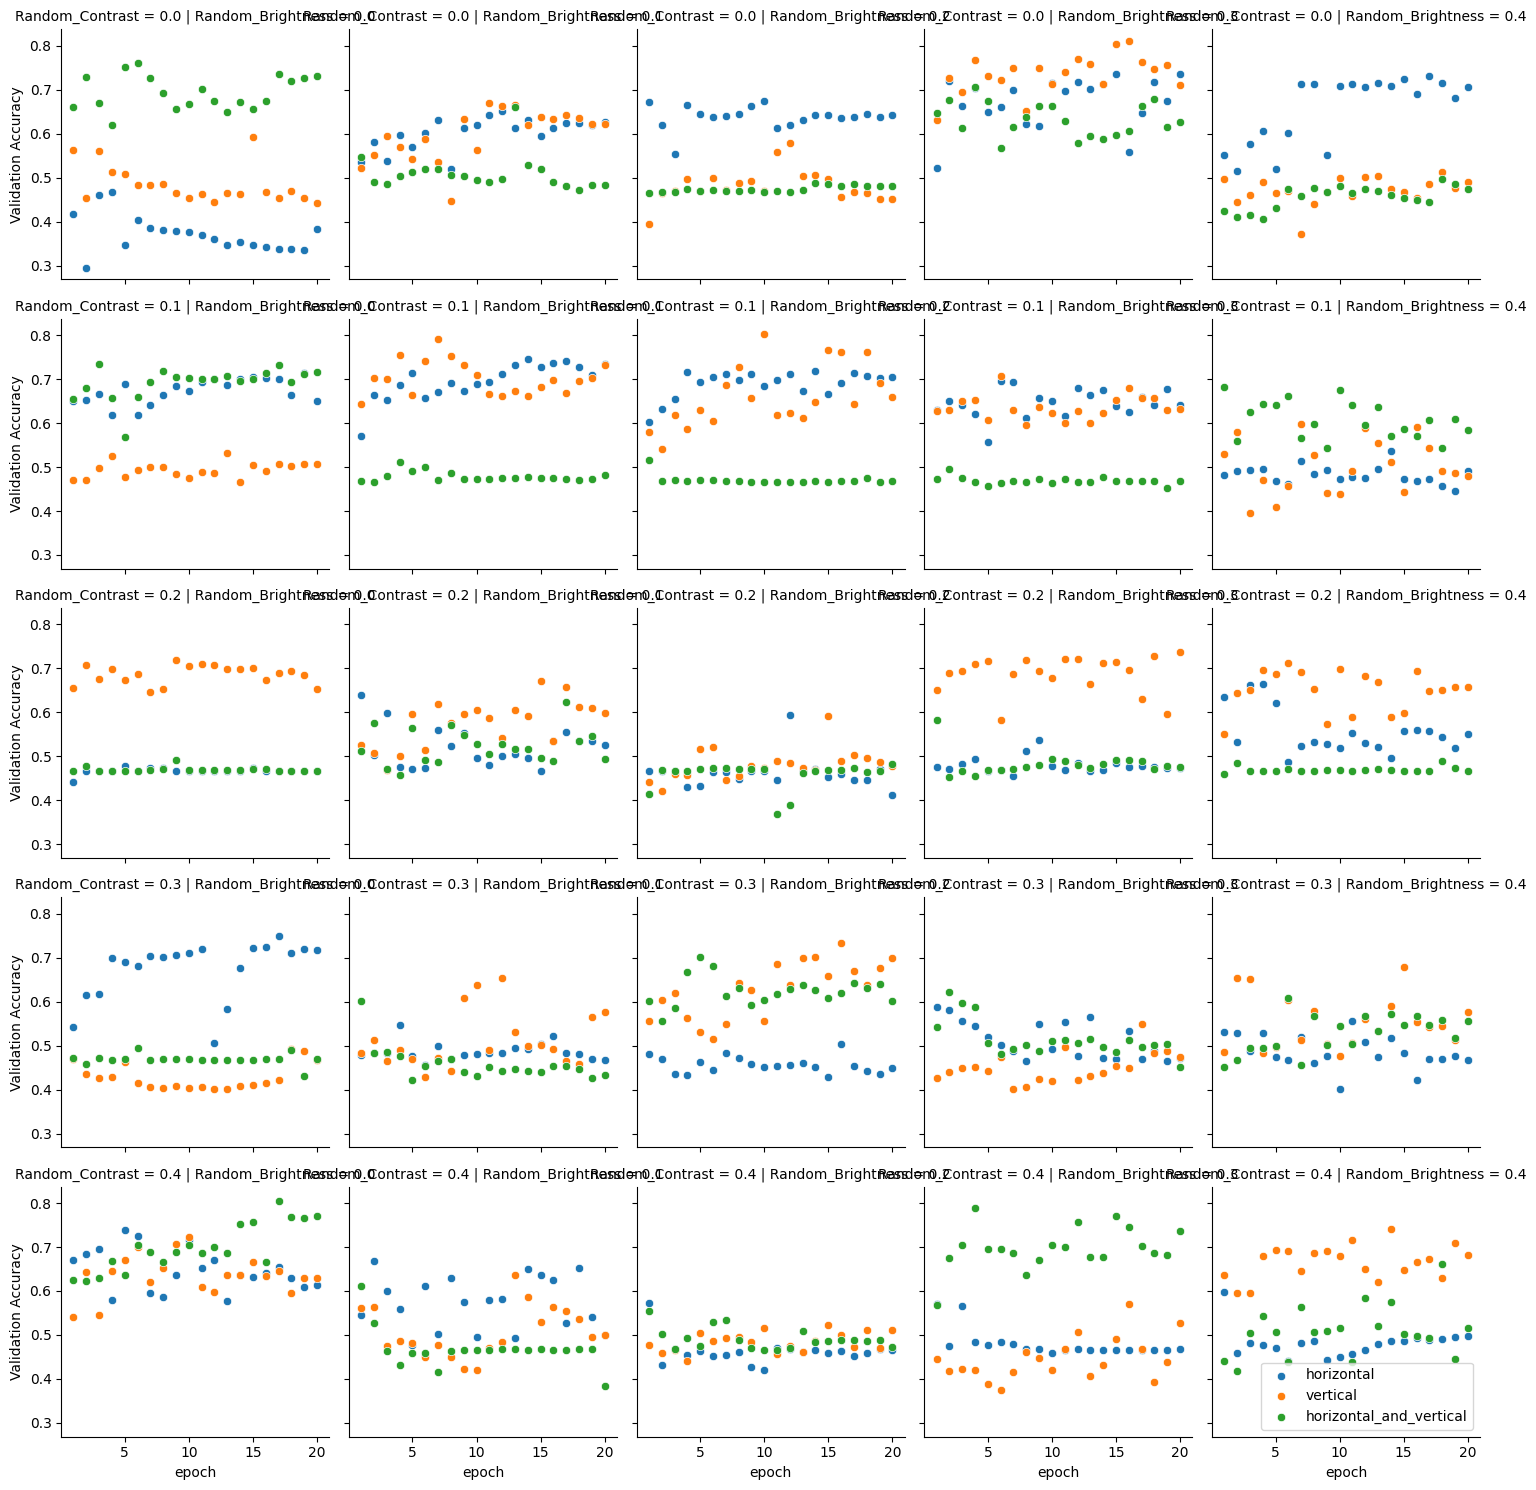

In [12]:
g = sns.FacetGrid(df, col = 'Random_Brightness', row = 'Random_Contrast', hue='Random_Flip')
g.map_dataframe(sns.scatterplot, x='epoch', y='Validation Accuracy')
plt.tight_layout()
plt.legend()